In [1]:
# import the necessary libraries
import matplotlib.pyplot as plt
import warnings
from rfpimp import *
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [2]:
#reading the entire data in the file into pandas dataframe
df = pd.read_csv('data/train.csv'); df.shape

(37670293, 24)

In [3]:
# collecting rows that are hotel_cluster_0~9. check 
dfn = df.loc[df['hotel_cluster'].isin(list(range(10)))]; dfn.shape

(3920622, 24)

In [4]:
#check which columns have how many null values 
dfn.isnull().sum()

date_time                          0
site_name                          0
posa_continent                     0
user_location_country              0
user_location_region               0
user_location_city                 0
orig_destination_distance    1390238
user_id                            0
is_mobile                          0
is_package                         0
channel                            0
srch_ci                         4781
srch_co                         4782
srch_adults_cnt                    0
srch_children_cnt                  0
srch_rm_cnt                        0
srch_destination_id                0
srch_destination_type_id           0
is_booking                         0
cnt                                0
hotel_continent                    0
hotel_country                      0
hotel_market                       0
hotel_cluster                      0
dtype: int64

In [5]:
# separating the target variable and the predictor variables
df_X = dfn.drop(columns=['hotel_cluster'])
df_y = dfn['hotel_cluster']

### Using data with 1mil rows to fit model and find a candidate of good model

In [7]:
# using stratified shuffle split to get 25% of the filter data while keeping the distribution (~ 1mil samples)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.25, random_state=0)
for train_idx, test_idx in sss.split(df_X, df_y):
    X_train, X_test = df_X.iloc[train_idx], df_X.iloc[test_idx]
    y_train, y_test = df_y.iloc[train_idx], df_y.iloc[test_idx]

In [8]:
#check the shape of training and testing data
print(f"X_train {X_train.shape}, y_train {y_train.shape}\n X_test {X_test.shape}, y_test {y_test.shape}")

X_train (980155, 23), y_train (980155,)
 X_test (2940467, 23), y_test (2940467,)


In [9]:
#reset the index
sample_x = X_train.reset_index(drop=True)
sample_y = y_train.reset_index(drop=True)
sample_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980155 entries, 0 to 980154
Data columns (total 23 columns):
date_time                    980155 non-null object
site_name                    980155 non-null int64
posa_continent               980155 non-null int64
user_location_country        980155 non-null int64
user_location_region         980155 non-null int64
user_location_city           980155 non-null int64
orig_destination_distance    633029 non-null float64
user_id                      980155 non-null int64
is_mobile                    980155 non-null int64
is_package                   980155 non-null int64
channel                      980155 non-null int64
srch_ci                      978936 non-null object
srch_co                      978936 non-null object
srch_adults_cnt              980155 non-null int64
srch_children_cnt            980155 non-null int64
srch_rm_cnt                  980155 non-null int64
srch_destination_id          980155 non-null int64
srch_destination_

In [10]:
# feature engineering into datetime
sample_x['date_time'] = pd.to_datetime(sample_x['date_time'], yearfirst=True)
sample_x['srch_ci'] = pd.to_datetime(sample_x['srch_ci'], yearfirst=True, errors='coerce')
sample_x['srch_co'] = pd.to_datetime(sample_x['srch_co'], yearfirst=True, errors='coerce')

# timedelta for days in advance feature
sample_x['advance'] = sample_x['srch_ci'] - sample_x['date_time']
sample_x['advance'] = sample_x.advance.dt.days

# duration of stays
sample_x['duration'] = sample_x['srch_co'] - sample_x['srch_ci']
sample_x['duration'] = sample_x.duration.dt.days

In [11]:
new_x = sample_x.drop(columns=['user_id', 'site_name',
                               'user_location_region',
                               'date_time', 'srch_ci',
                               'srch_co'])

In [12]:
new_x.shape

(980155, 19)

In [13]:
# Train test split the 5% data
xtrain, xtest, ytrain, ytest = train_test_split(new_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((784124, 19), (196031, 19))

In [14]:
# Building the pipeline
def make_pipeline():
    """This function here makes the pipeline but does not include the clf to prevent data leakage."""
    
    date_features = ['advance', 'duration']
    date_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))])

    distance = ['orig_destination_distance']
    distance_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    preprocessor = ColumnTransformer(transformers=[('date', date_transformer, date_features),
                                                   ('dist', distance_transformer, distance)],
                                    remainder='passthrough')

    pipeline = Pipeline([('preprocess', preprocessor)])
    
    return pipeline

### AutoML for Decision Tree

In [15]:
def make_random_cv(cv, n_iter, n_estimators):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    
    rf = DecisionTreeClassifier(random_state=42, 
                                max_depth=10)
    
    params_grid = {'max_features': [2, 5, 10, 16],
                  'min_samples_leaf': [100, 500, 1000, 2000]}
    
    clf_random_cv = RandomizedSearchCV(estimator=rf, scoring='f1_weighted',
                                       param_distributions=params_grid,
                                       n_iter=n_iter, cv=cv)
                                         
    return clf_random_cv

In [16]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.fit_transform(xtest)
trans_xtrain.shape # sanity check of datashape

(784124, 19)

In [17]:
# creating the RandomizedSearchCV and using the best estimator
randomize_clf = make_random_cv(3, 5, 1) # 3-fold, 5 iterations
randomize_clf.fit(trans_xtrain, ytrain)
best_rf = randomize_clf.best_estimator_ # returning the best estimator
randomize_clf.best_params_

{'min_samples_leaf': 100, 'max_features': 16}

In [18]:
# fitting the best estimator and getting the training scores
best_rf.fit(trans_xtrain, ytrain)
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")

Training weighted-f1-Score: 0.5220213513642131


In [19]:
# transforming the test data and evaluating the model

# does this fit the testing data and then transform? 
trans_xtest = pipeline.fit_transform(xtest) # #What if I want to impute based on the training data to prevent data leakage
print(f"Test Accuracy: {accuracy_score(ytest, best_rf.predict(trans_xtest))}")
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")

Test Accuracy: 0.5306609668878902
Training weighted-f1-Score: 0.5220213513642131


In [20]:
# Training the default decision tree model 
dt = DecisionTreeClassifier()
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, dt.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, dt.predict(trans_xtest))}")

Training Accuracy Score: 0.9953986869423713
Testing Accuracy Score: 0.5865653901678816


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
# Training Classification Report
print(classification_report(ytrain, dt.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75918
           1       1.00      1.00      1.00     90583
           2       0.99      1.00      0.99     86805
           3       0.99      1.00      1.00     45062
           4       1.00      1.00      1.00     70263
           5       0.99      0.99      0.99    124021
           6       1.00      0.99      1.00     76828
           7       1.00      0.99      1.00     50547
           8       1.00      0.99      0.99     66269
           9       1.00      0.99      0.99     97828

    accuracy                           1.00    784124
   macro avg       1.00      1.00      1.00    784124
weighted avg       1.00      1.00      1.00    784124



In [24]:
# Testing Classification Report
print(classification_report(ytest, dt.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     19055
           1       0.99      0.99      0.99     22590
           2       0.50      0.50      0.50     21825
           3       0.48      0.48      0.48     11251
           4       0.54      0.54      0.54     17699
           5       0.47      0.47      0.47     31027
           6       0.46      0.46      0.46     19270
           7       0.54      0.55      0.55     12565
           8       0.65      0.64      0.65     16495
           9       0.49      0.50      0.49     24254

    accuracy                           0.59    196031
   macro avg       0.59      0.59      0.59    196031
weighted avg       0.59      0.59      0.59    196031



In [25]:
from matplotlib.legend_handler import HandlerLine2D

## Hpyerparameter tuning manually for DecisionTree

### max_depth

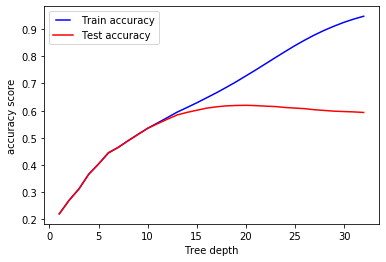

In [26]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(trans_xtrain, ytrain)
    
    acc_train = accuracy_score(ytrain, dt.predict(trans_xtrain))
    train_results.append(acc_train)
    
    acc_test = accuracy_score(ytest, dt.predict(trans_xtest))
    test_results.append(acc_test)
    
line1, = plt.plot(max_depths, train_results, "b", label= "Train accuracy")
line2, = plt.plot(max_depths, test_results, "r", label= "Test accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("accuracy score")
plt.xlabel("Tree depth")
plt.show()

### max_features

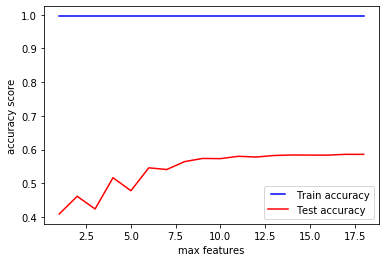

In [27]:
max_features = list(range(1,trans_xtrain.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(trans_xtrain, ytrain)

    acc_train = accuracy_score(ytrain, dt.predict(trans_xtrain))
    train_results.append(acc_train)
    
    acc_test = accuracy_score(ytest, dt.predict(trans_xtest))
    test_results.append(acc_test)
    
line1, = plt.plot(max_features, train_results, "b", label= "Train accuracy")
line2, = plt.plot(max_features, test_results, "r", label= "Test accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("accuracy score")
plt.xlabel("max features")
plt.show()    
    

In [28]:
# Training the decision tree model with max_depth and max_feature parameters
dt = DecisionTreeClassifier(max_depth=20, max_features=17)
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=17, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, dt.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, dt.predict(trans_xtest))}")

Training Accuracy Score: 0.7270635766791987
Testing Accuracy Score: 0.6166881768699849


## Using all the data (~4mil samples) for models training and testing

In [30]:
#reset the index
sample_x = df_X.reset_index(drop=True)
sample_y = df_y.reset_index(drop=True)
sample_x.info()

# feature engineering into datetime
sample_x['date_time'] = pd.to_datetime(sample_x['date_time'], yearfirst=True)
sample_x['srch_ci'] = pd.to_datetime(sample_x['srch_ci'], yearfirst=True, errors='coerce')
sample_x['srch_co'] = pd.to_datetime(sample_x['srch_co'], yearfirst=True, errors='coerce')

# timedelta for days in advance feature
sample_x['advance'] = sample_x['srch_ci'] - sample_x['date_time']
sample_x['advance'] = sample_x.advance.dt.days

# duration of stays
sample_x['duration'] = sample_x['srch_co'] - sample_x['srch_ci']
sample_x['duration'] = sample_x.duration.dt.days

new_x = sample_x.drop(columns=['user_id', 'site_name',
                               'user_location_region',
                               'date_time', 'srch_ci',
                               'srch_co'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920622 entries, 0 to 3920621
Data columns (total 23 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(19), object(3)
memory usage: 688.0+ MB


In [31]:
# Train test split the 5% data
xtrain, xtest, ytrain, ytest = train_test_split(new_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((3136497, 19), (784125, 19))

In [32]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.fit_transform(xtest)
trans_xtrain.shape # sanity check of datashape

(3136497, 19)

In [33]:
# Training the decision tree model with max_depth, max_feature,  parameter
dt = DecisionTreeClassifier(max_depth=20, max_features=17)
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=17, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [34]:
# accuracy
print(f"Training Accuracy Score: {round(accuracy_score(ytrain, dt.predict(trans_xtrain)), 2)}")
print(f"Testing Accuracy Score: {round(accuracy_score(ytest, dt.predict(trans_xtest)), 2)}")

Training Accuracy Score: 0.69
Testing Accuracy Score: 0.65


In [35]:
# F1-scores
print(f"Training weighted-f1-Score: {round(f1_score(ytrain, dt.predict(trans_xtrain), average='weighted'), 2)}")
print(f"Testing weighted-f1-Score: {round(f1_score(ytest, dt.predict(trans_xtest), average='weighted'), 2)}")

Training weighted-f1-Score: 0.68
Testing weighted-f1-Score: 0.64


In [36]:
# precision 
print(f"Training Precision Score: {precision_score(ytrain, dt.predict(trans_xtrain), average='weighted')}")
print(f"Testing Precision Score: {precision_score(ytest, dt.predict(trans_xtest), average='weighted')}")

Training Precision Score: 0.6877228759312799
Testing Precision Score: 0.6473328601812063


## Piplelines for LR and KNN

In [37]:
def make_pipelines():
    """Create a pipeline for each of the following algorithms:
    1. Logistic Regression
    2. k-nearest neighbors (KNN) 
    3. Naive Bayes (Guassian)
    4. Support Vector Machines (SVM)
    5. Random Forest™ 
    
    If appropriate, apply StandardScaler before the algorithm.   
    Use default hyperparameters.
    If an algorithm takes random_state then random_state=42 
    
    Return a list of all the pipelines.
    """ 
    pipe_log = Pipeline([('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs' ))])
    pipe_knn = Pipeline([('clf', KNeighborsClassifier())])
    

    pipelines = [pipe_log, pipe_knn]
    
    return pipelines

In [38]:
pipelines = make_pipelines(); pipelines

[Pipeline(memory=None,
          steps=[('clf',
                  LogisticRegression(C=1.0, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='multinomial', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('clf',
                  KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                       metric='minkowski', metric_params=None,
                                       n_jobs=None, n_neighbors=5, p=2,
                                       weights='uniform'))],
          verbose=False)]

In [41]:
#precision score
def sort_models(pipelines, X_data, y_data, metric=accuracy_score, average="weighted"):
#     scores_sorted = {}

    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred, average=average), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [42]:
sort_models(pipelines, trans_xtest, ytest, metric=precision_score)

test socre with LogisticRegression is 0.13
test socre with KNeighborsClassifier is 0.62


In [44]:
#accuracy score
def sort_models(pipelines, X_data, y_data, metric=accuracy_score):
#     scores_sorted = {}

    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [45]:
sort_models(pipelines, trans_xtest, ytest, metric=accuracy_score)

test socre with LogisticRegression is 0.19
test socre with KNeighborsClassifier is 0.62


[('LogisticRegression', 0.19), ('KNeighborsClassifier', 0.62)]

In [ ]:
sort_models(pipelines, trans_xtest, ytest, metric=f1_score)